# Demo Preprocessing

Demonstrating the preprocessing functionality of INSTA, the in situ transcriptomics analysis pipeline.

### Functionality demonstrated: 
- parameter extraction 
- blob detection, using parameter extraction
- autocropping

In [1]:
from skimage.feature import blob_log
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import os, warnings

In [2]:
from instapipeline import QuantiusAnnotation, SpotAnnotationAnalysis, autocrop, param

In [3]:
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## User Inputs

In [4]:
margin = 4					# margin around each spot, in pixels
correctness_threshold = 10
max_num_crops = 7
colors = ['cyan', 'blue', 'purple', 'violet', 'magenta', 'red', 'orange', 'yellow', 'green', ]    
crosshair_ratio = 0.04
max_num_crops = 4
max_crowded_ratio = 0.3

In [5]:
img_filename = 'ISS_rnd0_ch3_z0.png'
img_path = './image/' + img_filename
expert_filename = 'ISS_rnd0_ch3_z0.csv'
expert_path = './expert/' + expert_filename

In [6]:
results = []

#### Sanity check: expert annotations and image line up

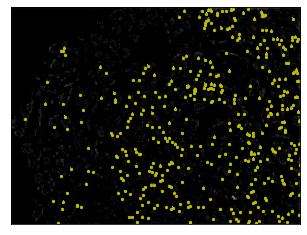

In [7]:
im = imread(img_path, as_gray=True)
ref = np.asarray(pd.read_csv(expert_path))
for x, y in ref:
    plt.scatter([x], [y], color='y', s=5)
plt.imshow(im, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

# Test Parameter Extraction

In [8]:
if not os.path.exists('./spot_params/'):
    os.mkdir('./spot_params/')
expert_coords = np.genfromtxt(expert_path, delimiter=',')[1:]
sigma_list = param.get_sigma_list(img_path, expert_coords, margin)
np.savetxt('./spot_params/param_extraction_sigmas.csv', sigma_list, delimiter=',')

In [9]:
reference_sigma_list = np.asarray(pd.read_csv('./expected_outputs/param_extraction_sigmas.csv', header=None))

result = 'Pass: found expected sigmas'
for x, y in zip(sigma_list, reference_sigma_list):
    if abs(x - y[0]) > 0.000001:
        result = 'Fail: did not find expected sigmas'
print(result)
results.append(result)

Pass: found expected sigmas


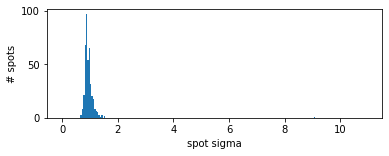

In [10]:
sigma_list = np.asarray(pd.read_csv('./spot_params/param_extraction_sigmas.csv'))
sigma_list = [x[0] for x in sigma_list]
plt.figure(figsize=(6,2))
plt.hist(sigma_list, bins=np.arange(0, 11, 0.05))
plt.yticks([0, 50, 100])
plt.xlabel('spot sigma')
plt.ylabel('# spots')
plt.show()

#### Expected output:

<img src="expected_outputs/sigma_hist.png" style="width: 390px;" align="left"/>

In [11]:
# Assign a range of intensity thresholds to test.
thresholds = np.arange(0.1, 0.4, 0.03)

# Run blob detection with a range of thresholds and find the best threshold.
best_threshold, best_recall, best_precision, recall_list, precision_list = param.get_best_threshold(
    expert_coords, img_path, min(sigma_list), max(sigma_list), correctness_threshold, thresholds)

np.savetxt('./spot_params/param_extraction_precision.csv', precision_list, delimiter=',')
np.savetxt('./spot_params/param_extraction_recall.csv', recall_list, delimiter=',')

In [12]:
reference_precision_list = np.asarray(pd.read_csv('./expected_outputs/param_extraction_precision.csv', header=None))
reference_recall_list = np.asarray(pd.read_csv('./expected_outputs/param_extraction_recall.csv', header=None))

result = 'Pass: found expected precisions'
for x, y in zip(precision_list, reference_precision_list):
    if abs(x - y[0]) > 0.000001:
        result = 'Fail: did not find expected precisions'
print(result)
results.append(result)

result = 'Pass: found expected recalls'
for x, y in zip(recall_list, reference_recall_list):
    if abs(x - y[0]) > 0.000001:
        result = 'Fail: did not find expected recalls'
print(result)
results.append(result)

Pass: found expected precisions
Pass: found expected recalls


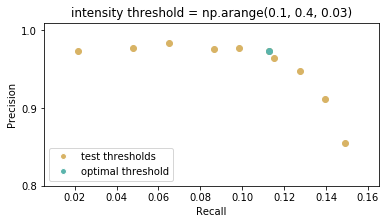

In [13]:
precision_list = np.asarray(pd.read_csv('./spot_params/param_extraction_precision.csv'))
recall_list = np.asarray(pd.read_csv('./spot_params/param_extraction_recall.csv'))
best_recall = recall_list[4]
best_precision = precision_list[4]

plt.figure(figsize = (6, 3))
plt.scatter(recall_list, precision_list, c='#d8b365')
plt.scatter([best_recall], [best_precision], c='#5ab4ac')
plt.xlabel('Recall')
plt.yticks([.8, .9, 1])
plt.ylabel('Precision')

handle1 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#d8b365', label='test thresholds')
handle2 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#5ab4ac', label='optimal threshold')
plt.legend(handles=[handle1, handle2], loc='lower left')

plt.title('intensity threshold = np.arange(0.1, 0.4, 0.03)')
plt.show()

### Expected output:

<img src="expected_outputs/find_intensity_threshold.png" style="width: 390px;" align="left"/>

## Print and save blob detection parameters
The min sigma, max sigma, and optimal intensity threshold found above with parameter extraction are now considered "tuned" parameters. 
If we are satisfied with them, we can use them with blob_log() on other smFISH chemistries.

In [14]:
min_sigma = min(sigma_list)
max_sigma = max(sigma_list)

print('smallest spot_sigma = %f' % (round(min_sigma, 2)))
print('greatest spot_sigma = %f' % (round(max_sigma, 2)))
print('optimal intensity threshold = %f' % (round(best_threshold, 2)))

if round(min_sigma, 2) == 0.68 and round(max_sigma, 2) == 9.070000 and round(best_threshold, 2) == 0.13:
    result = 'Pass: found expected blob detection parameters'
else:
    result = 'Fail: did not find expected blob detection parameters'
    
print(result)
results.append(result)
np.savetxt('./spot_params/spot_params.csv', [[min_sigma, max_sigma, best_threshold]], header='min_sigma,max_sigma,best_threshold', delimiter=",", comments='')

smallest spot_sigma = 0.680000
greatest spot_sigma = 9.070000
optimal intensity threshold = 0.130000
Pass: found expected blob detection parameters


### Expected output:

- smallest spot_sigma = 0.68
- greatest spot_sigma = 9.07
- optimal intensity threshold =0.13

# Test Blob Detection

In [15]:
# Run blob_log() on all test images using min_sigma, max_sigma, and best_threshold found above.

blob_params = pd.read_csv('./spot_params/spot_params.csv')
min_sigma = blob_params['min_sigma'][0]
max_sigma = blob_params['max_sigma'][0]
best_threshold = blob_params['best_threshold'][0]

im = imread(img_path, as_gray=True)
img_height = len(im)

if not os.path.exists('./blobs/'):
    os.mkdir('./blobs/')

blob_path = './blobs/blobs.csv'

blobs_log = blob_log(im, max_sigma=max_sigma, min_sigma=min_sigma, num_sigma=10, threshold=best_threshold)
blobs = [[c, r] for r, c, sigma in blobs_log]

np.savetxt(blob_path, blobs, header='x,y', delimiter=",", comments='')

In [16]:
reference_blobs_list = np.asarray(pd.read_csv('./expected_outputs/blobs.csv'))
if (reference_blobs_list == blobs).all():
    result = 'Pass: found expected blobs'
else:
    result = 'Fail: did not find expected blobs'
print(result)
results.append(result)

Pass: found expected blobs


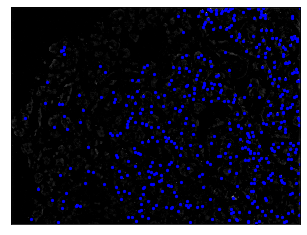

In [17]:
# Plot blobs
blobs = np.asarray(pd.read_csv(blob_path))
plt.figure()
im = imread(img_path)
plt.imshow(im, cmap='gray')
for x, y in blobs:
    plt.scatter([x], [y], color='blue', s=5)
plt.xlim(0, im.shape[1])
plt.ylim(0, im.shape[0])
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.show()

### Expected output:

<img src="expected_outputs/blobs.png" style="width: 305px;" align="left"/>

# Test Autocropping

In [18]:
if not os.path.exists('./crops/'):
    os.mkdir('./crops/')
img_name = 'ISS_rnd0_ch3_z0'
crop_dir = 'test_crops'
parent_dir = 'image'

blob_path = './blobs/blobs.csv'
blobs = np.asarray(pd.read_csv(blob_path))

image_width = imread(img_path).shape[1]
crosshair_arm_length = crosshair_ratio * image_width

autocrop.autocrop(blobs, img_name, crosshair_arm_length, max_num_crops, max_crowded_ratio, crop_dir, parent_dir)

In [19]:
result = 'Pass: found expected crops'
for j in range(4):
    ref_path = './reference/%s_%s.csv' % (img_name, j)
    ref = np.genfromtxt(ref_path, delimiter=',')
    
    csv_path = './crops/%s_%s.csv' % (img_name, j)
    crop = np.genfromtxt(csv_path, delimiter=',')
    
    if crop[0] != ref[0] or crop[1] != ref[1] or crop[2] != ref[2] or crop[3] != ref[3]:
        result = 'Fail: did not find expected crops'
    
results.append(result)

Plot crops for ISS_rnd0_ch3_z0

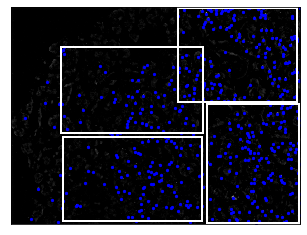

In [20]:
blob_path = './blobs/blobs.csv'
blobs = np.asarray(pd.read_csv(blob_path))

fig,ax = plt.subplots(1)
im = imread(img_path)
plt.imshow(im, cmap='gray')
for x, y in blobs:
    plt.scatter([x], [y], color='blue', s=5)
plt.xlim(0, im.shape[1])
plt.ylim(0, im.shape[0])

for j in range(4):
    csv_path = './crops/%s_%s.csv' % (img_name, j)
    crop = np.genfromtxt(csv_path, delimiter=',')
    rect = Rectangle((crop[0], crop[2]), crop[1]-crop[0], crop[3]-crop[2], edgecolor='w', facecolor='none', linewidth=2)
    ax.add_patch(rect)

plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.show()

### Expected output:

<img src="expected_outputs/autocrops.png" style="width: 305px;" align="left"/>

In [21]:
print('Test summary:')
results

Test summary:


['Pass: found expected sigmas',
 'Pass: found expected precisions',
 'Pass: found expected recalls',
 'Pass: found expected blob detection parameters',
 'Pass: found expected blobs',
 'Pass: found expected crops']